In [150]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer, OrdinalEncoder
from sklearn.linear_model import SGDRegressor, Lasso, RANSACRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import mlflow
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mlflow.models import infer_signature
from sklearn.model_selection import GridSearchCV

In [151]:
data = pd.read_csv('housing.csv', sep=',')

In [152]:
ohe = OneHotEncoder(sparse_output=False)
ocean_proximity_encoded = ohe.fit_transform(data[['ocean_proximity']]) 
ocean_proximity_columns = ohe.get_feature_names_out(['ocean_proximity']) 

df_ocean_proximity = pd.DataFrame(ocean_proximity_encoded, columns=ocean_proximity_columns)

data = pd.concat([data, df_ocean_proximity], axis=1) 
data.drop(columns=['ocean_proximity'], inplace=True) 
data.dropna(axis=0, how='any', inplace=True)
# data['total_bedrooms'] = data['total_bedrooms'].fillna(data['total_bedrooms'].median())

scaler = StandardScaler()
X = data.drop(columns=['median_income']) 
X = scaler.fit_transform(X)  

y = data['median_income'].values.reshape(-1, 1)
power_trans = PowerTransformer()
y = power_trans.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [153]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [ ]:
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1 ],
      'l1_ratio': [0.001, 0.05, 0.01, 0.2],
      'epsilon': np.linspace(0, 0.9, 4)
}
 
with mlflow.start_run():

    lr = SGDRegressor(random_state=42)
    # lr = Lasso()
    clf = GridSearchCV(lr, params, cv = 5, n_jobs=8)
    clf.fit(X_train, y_train.reshape(-1))
    best = clf.best_estimator_
    y_pred = best.predict(X_val)
    y_price_pred = power_trans.inverse_transform(y_pred.reshape(-1,1))
    y_price_pred = np.nan_to_num(y_price_pred, nan=0.0)
    (rmse, mae, r2)  = eval_metrics(power_trans.inverse_transform(y_val), y_price_pred)
    alpha = best.alpha
    l1_ratio = best.l1_ratio
    epsilon = best.epsilon
    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("epsilon", epsilon)
    
    predictions = best.predict(X_train)
    signature = infer_signature(X_train, predictions)
    mlflow.sklearn.log_model(lr, "model", signature=signature)

In [ ]:
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}
 
with mlflow.start_run():

    rf = RandomForestRegressor(random_state=42)
    clf = GridSearchCV(rf, params, cv = 5, scoring='r2', n_jobs=8)
    clf.fit(X_train, y_train.reshape(-1))
    best = clf.best_estimator_
    y_pred = best.predict(X_val)
    y_price_pred = power_trans.inverse_transform(y_pred.reshape(-1,1))
    y_price_pred = np.nan_to_num(y_price_pred, nan=0.0)
    (rmse, mae, r2)  = eval_metrics(power_trans.inverse_transform(y_val), y_price_pred)
    n_estimators = best.n_estimators
    max_depth = best.max_depth
    min_samples_split = best.min_samples_split
    min_samples_leaf = best.min_samples_leaf
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("n_estimators", n_estimators)
    mlflow.log_metric("max_depth", max_depth)
    mlflow.log_metric("min_samples_split", min_samples_split)



    predictions = best.predict(X_train)
    signature = infer_signature(X_train, predictions)
    mlflow.sklearn.log_model(lr, "model", signature=signature)

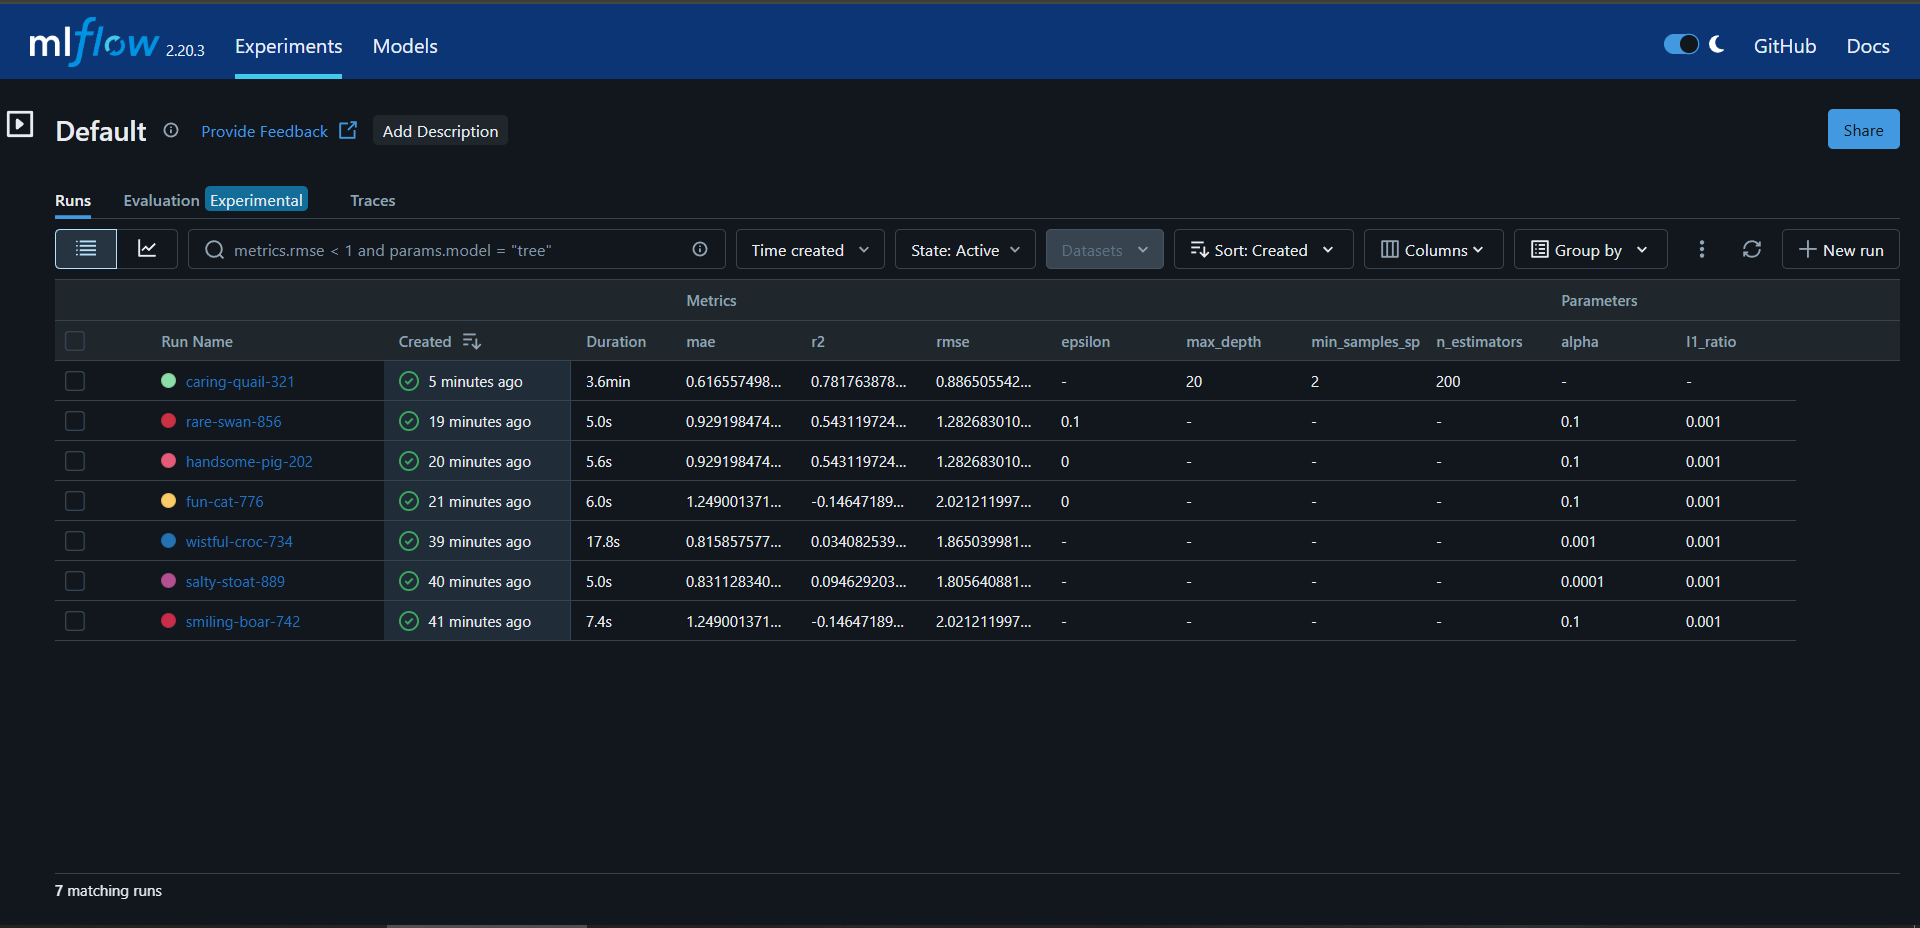

Лучше всего по всем параметам проявила себя последняя модель, использующая алгоритм RandomForestRegressor, а не SGDRegressor